# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [1]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-19 18:12:59--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-19 18:12:59 (31.8 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/bef019f/releases/pybind11-install.s

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v) 
- <\sigma \cdot n, v>_{\Gamma}
$

To model 

We seek a finite element approximation $u\in V$ such that 

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$. 



# **Method**

**Define domain and mesh**

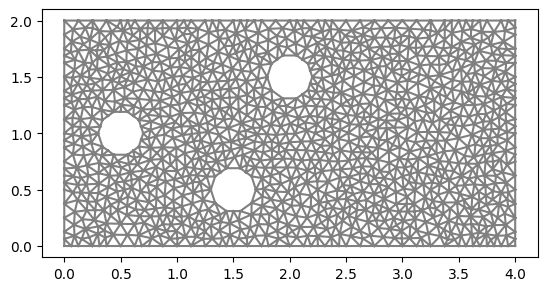

In [67]:
# Define rectangular domain 
L = 4.0
H = 2.0

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(1.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [68]:
# Generate finite element space
VE = VectorElement("CG", mesh.ufl_cell(), 1)

V = FunctionSpace(mesh, VE)

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V) 

d = Function(V)

**Define boundary conditions**

In [69]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

disp_x = 0.0
disp_y = 0.5

bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), disp_x, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), disp_y, dbc_objects)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

# **Results**

**Define and solve variational problem**

In [70]:
f = Expression(("0.0","0.0"), element = V.ufl_element())

dim = u.geometric_dimension()
E = 1.0e7 # 5.0e7 1.0e11
nu = 0.3 # 0.4 0.2
mu = E*0.5/(1+nu)
lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

def epsilon(u):
    return 0.5*(grad(u) + 2*grad(u).T)



def sigma(u):
    #return 2.0*mu*epsilon(u)
    return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)


# Define variational problem on residual form: r(u,v) = 0
residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

au = lhs(residual)
Lu = rhs(residual)

A = assemble(au)
b = assemble(Lu)

[bc.apply(A, b) for bc in bcu]
[bc.apply(d.vector()) for bc in bcu]

solve(A, d.vector(), b, "bicgstab", "default")


20

**Visualize solution and export files**

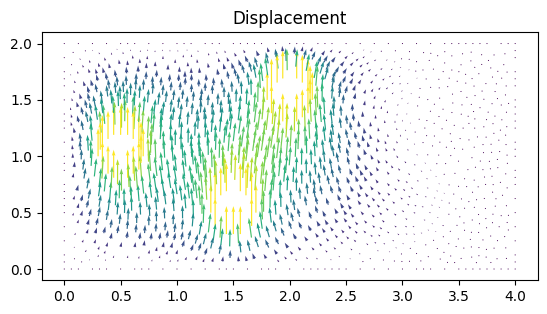

In [71]:
u1 = project(d, V)

# Plot solution
plt.figure()
plot(u1, title="Displacement")

plt.show()

**Update mesh**

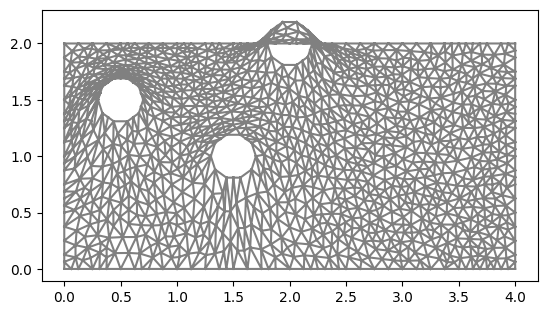

In [72]:
ALE.move(mesh, d)
plt.figure()
plot(mesh)
plt.show()

# **Discussion**

**Abstract**

The lab 4 is divided in two parts : the study of the ALE finite element method (lab 4 part 1) and the study of an elasticity model (lab 4 part 2). This is the second part of the lab 4. Here I am supposed to understand the impact of different parameters on the modification of the mesh. The mesh is an elastic solid which has a certain Young's modulus and a certain Poisson's ratio. I will first investigate the effect of these two parameters on the mesh and then I will study the impact of the movements of the cylinders. I would expect the mesh to have a physical answer to a certain deformation. 

**Introduction**

Observe how the elastic material (the mesh) is deformed as a response to how the cylinders are moved inside the domain. Modify Young's modulus and Poisson's ratio, how does the response change? Change the movement of the cylinders, how does that change the deformation of the material?  

**Methods**

For this lab, we are studying a mesh that represents a solid. It is a rectangular solid with cylindar holes inside. A movement of holes inside the solid will force the mesh to deform. The deformation is solved by an elasticity model. The equation that stands is a model of elasticity of the form $-\nabla \cdot \sigma = f$. By solving it with a variational method a velocity and a deformation will be computed on each node of the mesh and that will lead to a deformation of the mesh. The boundary conditions are of homogeneous Dirichlet type which means that the solid is supposed to be clamped on the edges.

**Results**

To observe the modification of the mesh I modify the second input of the function DirichletBC which is applied to the boundary conditions of the cylinders. If the second input is set at 0, then the object stays where it is. However if the second input is set at a value different than 0, then, to match the boundary conditions, the object has to move of the value specified in the in input of the function. I prefered to set the movement to 1 unit in the x-direction in order to see more deformation of the mesh.

I observe that as the cylinders are moving from the left to the right, the mesh is stretched on the left side of the cylinders and squizzed on the right side. I also observe that the more the cylinder is on the left the more stretched are the cells on the left of the cylinder. And on the contrary, the more the cylinder is on the right the more squizzed are the cells on the right of the cylinder. That is explain by the fact that the impact of the movement of a cylinder is independant of the amount of cells in the domain (to a certain limit). Therefore, if the amount of cells is small, then the impact will be strong. Finally, I observe that the cylinders have not anymore a circular shape, that may be due to the difficulty of the mesh to answer a strong movement of the cylinders.

Here I modify the Young's modulus and keep the Poisson's ratio constant equals to 0.3. 
- For a Young's modulus of 200 GPa (steel Young's modulus), the mesh is as stretched as with a Young's modulus of 10 GPa. 
- For a Young's modulus of 0.05 GPa (rubber Young's modulus), the mesh is also as stretched as with a Young's modulus of 10 GPa. 
I don't see major differences in the deformation of the mesh. I explain that by the fact that the movement of the cylinders are forced. I only simulate the deformation of the mesh after a certain movement but not the impact of a force of compression or expanssion on a solid.

Here I modify the Poisson's ratio and keep the Young's modulus constant equals to 10 GPa. I would expect the Poisson's ratio to have a strong impact on the deformation of the mesh in the y-direction because in the case studied here, the movement is in the x-direction.
- For a Poisson's ratio of 0.4 (gold Poisson's ratio) the mesh is more stretched in the y-direction than for a Poisson's ratio of 0.3. What I mean by that is that the cells behind the cylinders are stretched a lot in the y-direction.
- For a Poisson's ratio of 0.2 (concrete Poisson's ratio), the mesh is less stretched in the y-direction than for a Poisson's ratio of 0.3 or 0.4. 

To change the movement of the cylinders I just need to modify the second input of the function DirichletBC which is applied to the boundary conditions of the cylinders.

Here are presented all the modifications that I tried for a Young's modulus of 10 GPa and a Poisson's ratio of 0.3 :
- If the movement is in the y-direction (value of 0.5 unit in the + y_direction), one of the cylinder is leaving the domain and that causes a weird mesh deformation.
- If the movement is following a diagonal of the rectangle (value of 0.5 unit in the + y_direction and in the + x_direction), one of the cylinder is leaving the domain and that causes a weird mesh deformation.

If I don't take into account the cylinder that is leaving the domain, the movement being smaller than the previous simulations, the cylinder keep their circular shape. 




**Discussion**

In this assignment an elasticity equation was solved with a finite element method. Through this report, one can observe how is the mesh deformation according to the movement of holes inside the mesh and the impact of the elasticty parameters of the solid on the deformation of the mesh. 

